# Liquid cities tutorial

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import numpy.testing as npt
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2018-02-14 18:28:01


In [2]:
import invisible_cities.dataflow.dataflow as fl
from invisible_cities.sierpe  import fee as FE
import invisible_cities.core.system_of_units as units

In [3]:
from functools   import wraps
from functools   import reduce
from contextlib  import contextmanager
from collections import namedtuple
from typing import  NamedTuple

In [178]:
from numba import jit

## Tutorial

### Analysis flow

- Generation of toy waveforms representing the impulse response of a PMT
- Convolution with the FEE
- Deconvolution
- Comparison of the area of the original function with the area of the deconvoluted function

#### Waveform representation

In [8]:
class Waveform(NamedTuple):
    t   : np.ndarray
    q   : np.ndarray

#### A toy waveform function

- Simulate signal as a simple saw-function
- The effect of the electronics is (to first order) a HPF that introduces a derivative in the waveform

#### FEE instance (no noise)

In [53]:
fee_nn = FE.FEE(noise_FEEPMB_rms=0*units.mA, noise_DAQ_rms=0)

#### FEE instance including noise

In [54]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)

In [176]:
def input_and_fee_waveforms(fee):
    """
    generates a "theoretical" current signal (signal_i)
    """
    signal_i = np.concatenate((np.zeros(1000), 
                               np.linspace(0,0.5,2000), 
                               np.linspace(0.5,0,1000),
                               np.linspace(0,1,1000),
                               np.linspace(1,0,2000),
                               np.linspace(0,1,2000),
                               np.linspace(1,0,2000),
                               np.zeros(20000)),axis=0)*units.mA
    
    t = np.arange(0, np.size(signal_i), 1) * units.ns
    signal_out = FE.signal_v_fee(fee, signal_i, -1) * FE.v_to_adc()
    signal_out2 = FE.noise_adc(fee, signal_out)
    
    return Waveform(t, signal_i*FE.i_to_adc()), Waveform(t, signal_out2) 

In [72]:
wf_i, wf_o = input_and_fee_waveforms(fee)

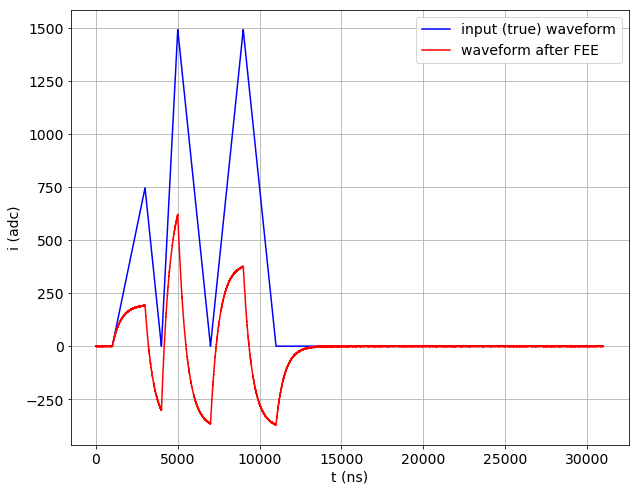

In [177]:
plt.plot(wf_i.t, wf_i.q, 'b', label='input (true) waveform')
plt.plot(wf_o.t, wf_o.q, 'r', label='waveform after FEE')
plt.grid(True)
plt.xlabel(r't (ns)')
plt.ylabel(r'i (adc)')
legend = plt.legend(loc='best')

### Deconvolution

- In the absence of noise, a simple deconvolution (deconv_simple) is sufficient.

In [180]:
@jit
def deconv_simple(signal, coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef * signal[0]
    for n in np.arange(1, len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [181]:
def blr(fee, wf):
    coef = fee.freq_LHPFd*np.pi
    signal_out_cf = FE.signal_clean(fee, wf.q, -1)
    signal_r, _ = deconv_simple(signal_out_cf, coef)
    return Waveform(wf.t, signal_r)
    

In [182]:
wf_r = blr(fee, wf_o)

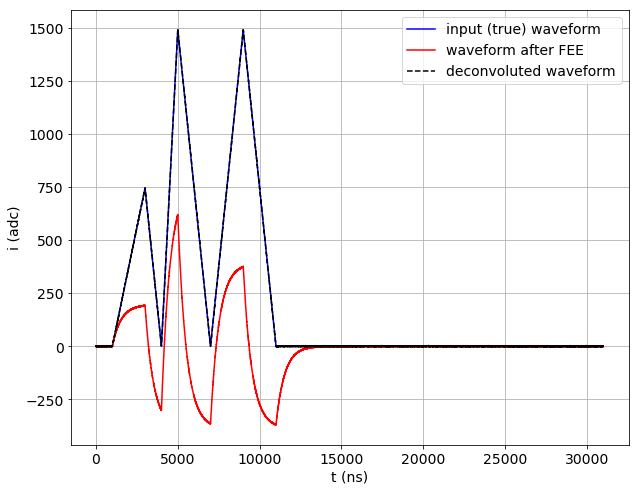

In [183]:
plt.plot(wf_i.t, wf_i.q, 'b', label='input (true) waveform')
plt.plot(wf_o.t, wf_o.q, 'r', label='waveform after FEE')
plt.plot(wf_r.t,wf_r.q,'k--', label='deconvoluted waveform')
plt.grid(True)
plt.xlabel(r't (ns)')
plt.ylabel(r'i (adc)')
legend = plt.legend(loc='best')

#### Excellent agreement between deconvoluted and original waveform

### Compare area of deconvoluted and original: show that difference is very small

In [184]:
def energy_comparison(wf_i, wf_r):
    energy_r = np.sum(wf_r.q[1000:11000])
    energy_i = np.sum(wf_i.q)
    return 100 * abs(energy_i - energy_r) / energy_i

In [185]:
def noise_calculation(wf_fee):
    return np.std(wf_fee.q[25000:26000], ddof=1)
    

In [188]:
energy_diff = energy_comparison(wf_i, wf_r)
print('Error in Energy Computation (%) = {}'.format(energy_diff))
print('FEE noise  = {}'.format(noise_calculation(wf_fee)))

Error in Energy Computation (%) = 0.04224976503519282
FEE noise  = 0.8828990035125438


## Loop based analysis

In [190]:
events_to_run = 1000
ediff = []
noise = []

for event_number in range(events_to_run):
    wf_i, wf_fee =input_and_fee_waveforms(fee)
    wf_r         = blr(fee, wf_fee)
    
    ediff.append(energy_comparison(wf_i, wf_r))
    noise.append(noise_calculation(wf_fee))

h_noise, _ = np.histogram(noise, bins=10)
h_ediff, _ = np.histogram(ediff, bins=10)


    

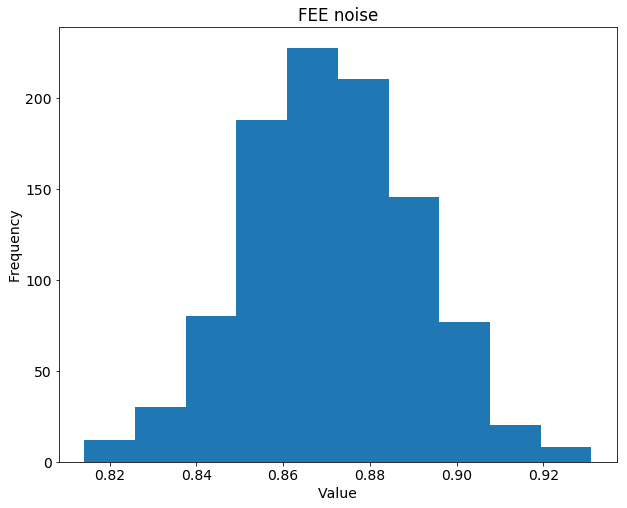

In [195]:
h2_noise, _, _ = plt.hist(noise, 10)
plt.title("FEE noise")
plt.xlabel("Value")
plt.ylabel("Frequency")

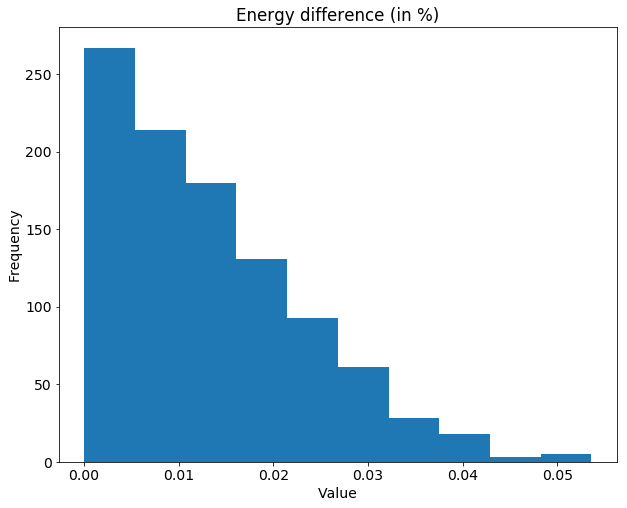

In [193]:
h2_ediff, _, _ = plt.hist(ediff, 10)
plt.title("Energy difference (in %)")
plt.xlabel("Value")
plt.ylabel("Frequency")

## Flow based analysis

## Analysis flow

- A flow needs: 

- A source, to generate the waveforms.
- A pipe where the data will be transformed
- A sink to collect the results of the analysis

## City components

### Source

In [198]:
def waveform_generator(fee, events):
    for event_number in range(events):
        wf_i, wf_fee =input_and_fee_waveforms(fee)
        yield dict(wf_i=wf_i, wf_fee=wf_fee, event_number=event_number)

### Maps the deconvolution of the waveform to the data flow

In [199]:
def waveform_deconvolution(fee):
    coef = fee.freq_LHPFd*np.pi
    
    def deconvolution_waveform(wf):
        signal_out_cf = FE.signal_clean(fee, wf.q, -1)
        signal_r, _ = deconv_simple(signal_out_cf,coef)
        return Waveform(wf.t, signal_r)
    return deconvolution_waveform

### Mpas the comparison of energy between true and deconvoluted waveforms to the data flow

In [200]:
def compare_energy(tmin=1000, tmax=11000):
    def energy_comparison(wf_i, wf_r):
        energy_r = np.sum(wf_r.q[tmin:tmax])
        energy_i = np.sum(wf_i.q)
        return 100 * abs(energy_i - energy_r)/energy_i
    return energy_comparison

### Maps the calculation of the FEE noise to the data flow

In [201]:
def calculate_noise(tmin=1000, tmax=11000):
    def noise_calculation(wf_fee):
        return np.std(wf_fee.q[tmin:tmax],ddof=1)
    return noise_calculation

In [202]:
def print_every(N):
    counter = fl.count()
    return fl.branch(fl.map  (lambda _: next(counter), args="event_number", out="index"),
                     fl.slice(None, None, N),
                     fl.sink (lambda data: print(f"events processed: {data['index']}, event number: {data['event_number']}")))


## City of Esmeralda

In a liquid city, functions are mapped to the data flow, usually by the operation 

*fl.map(function_to_be_mapped, args = ('input_data1, input_data2...), out = ('output_data1, output_data2...')*

For example, the operation of deconvolution takes as input deta the FEE waveforms, which have been sent to the data flow (by the source) with the name "wf_fee" (in waveform generator):

*yield dict(wf_i=wf_i, wf_fee=wf_fee, event_number=event_number)*

and outputs (to the data flow dict) deconvoluted waveforms, which are stored as "wf_r". Thus:

**deconvolution_waveform  = fl.map(waveform_deconvolution(fee), args="wf_fee" , out="wf_r")**

Notice that:

- waveform_deconvolution has been defined as a component. It returns a function that performs the deconvolution and is mapped to the data flow by fl.map. It accepts "wf_fee" from the data flow dictionary (previously put there by the source) and the data that it produces (the deconvoluted waveform) is sent to the data flow dictionary.

- deconvolution_waveform is the name of the component to go to the flow (a piece in the data transformation pipe). Notice the convention. The function inside the map is in attrgetter style (waveform_deconvolution), the function that goes to the pipe in the getattr style (deconvolution_waveform)

In Esmeralda the data is transformed as follows:

1. The source produces wf_i ("true waveforms") and wf_fee (waveforms with the effect of FEE)
2. The first transformation in the pipe deconvolutes the wf_fee waveform and produces Wf_r.
3. Then the data is forked towards two sinks. 

   3.1 The first pipe computes the difference between the energy of wf_i and the energy of wf_r and the sink accumulates the result in r_ediff. 
   3.2 The second pipe computes the noise of wf_fee and the sink accumulates the result in r_noise

4. The flow includes a counter and a slice to control the number of events that pass through the flow. 


In [212]:
def esmeralda(event_range=(0,100), print_mod=1, noise_f=1, noise_daq=1):
    """This city:
    - accepts waveforms ("true" and "convoluted") from the source
    - deconvolutes the waveforms
    - compares the deconvoluted ("blr") waveform with the "true" waveform, 
      producing an histogram of energy difference
    - produces an histogram of FEE noise
    """
    
    fee = FE.FEE(noise_FEEPMB_rms=noise_f * FE.NOISE_I, noise_DAQ_rms=noise_daq * FE.NOISE_DAQ)
    
  
    deconvolution_waveform  = fl.map(waveform_deconvolution(fee),           args="wf_fee" ,        out="wf_r")
    energy_comparison       = fl.map(compare_energy(tmin=1000, tmax=11000), args=("wf_i", "wf_r"), out="ediff_wi_wr")
    noise_calculation       = fl.map(calculate_noise(25000,26000),          args="wf_fee"        , out="noise_fee")
    
    r_ediff = []    
    r_noise = []
    
    ediff = fl.sink(r_ediff.append, args="ediff_wi_wr")   #the flow ends in a sink that fills the container
    noise = fl.sink(r_noise.append, args="noise_fee")    

    event_count = fl.count()  
    out = fl.push(
                  source =  waveform_generator(fee, event_range[1]),
                  pipe   = fl.pipe(fl.slice(*event_range),
                                   #print_every(print_mod),
                                   deconvolution_waveform,
                                   fl.fork((energy_comparison,   ediff),
                                           (noise_calculation,   noise),
                                           (        event_count.sink))),
                  result = (event_count.future))
    return out, r_ediff, r_noise
    
                                           

In [213]:
cnt,  ediff, noise = esmeralda(event_range=(0,1000), print_mod=1, noise_f=1, noise_daq=1)

In [217]:
print('number of events run = {}'.format(cnt))

number of events run = 1000


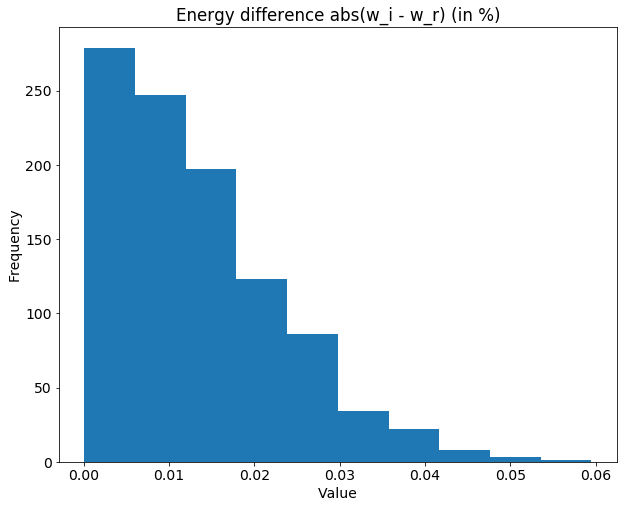

In [215]:
h2_ediff, _, _ = plt.hist(ediff, 10)
plt.title("Energy difference abs(w_i - w_r) (in %)")
plt.xlabel("Value")
plt.ylabel("Frequency")

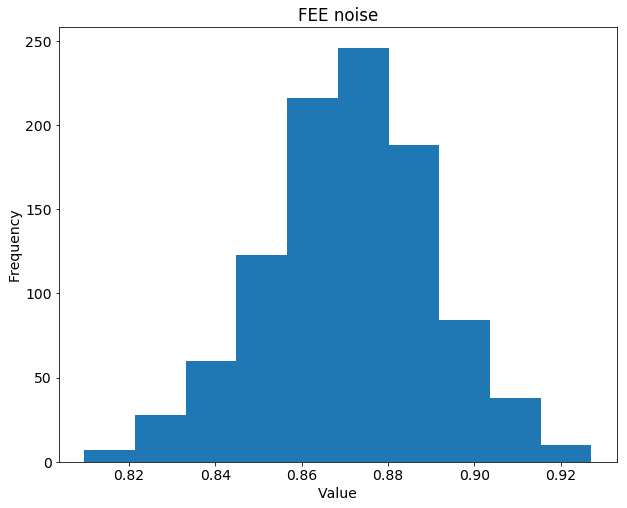

In [216]:
h2_noise, _, _ = plt.hist(noise, 10)
plt.title("FEE noise")
plt.xlabel("Value")
plt.ylabel("Frequency")